In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

In [4]:
ds = dgl.data.CSVDataset('./DGL_playground/toy_dataset/')

Done loading data from cached files.


In [5]:
g = ds[0]

In [6]:
print(g)


Graph(num_nodes=10, num_edges=20,
      ndata_schemes={' na2': Scheme(shape=(), dtype=torch.int64), ' na1': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'ea2': Scheme(shape=(), dtype=torch.int64), 'ea1': Scheme(shape=(), dtype=torch.int64), 'w': Scheme(shape=(), dtype=torch.int64)})


### Define Weights

The weights need to be constant along any bi-directed edge. DGL does not provide a function to ensure this happens. Currently a for loop is being used to ensure identical weights along edges - a better solution needs to be found to ensure scalability of the model.

In [7]:
g.edata['w'] = torch.rand(g.num_edges(),1)
# g.edata['w']

In [8]:
g.edges("all")

(tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]),
 tensor([1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]))

In [9]:
# Obtain source, destination and edge ids for all edges
[src, dst, eid] = g.edges(form = 'all')

# Loop through edges to identify bi-directional edges to then assign same weights
# This loop can be optimized but ideally needs to be replaced with an parallelisable function
for i in eid:
    for j in eid:
        if (src[i] == dst[j] and dst[i] == src[j]): #For edges with same nodes
            g.edata['w'][j] = g.edata['w'][i]
            break
g.edata['w']

tensor([[0.1481],
        [0.2770],
        [0.4437],
        [0.1481],
        [0.0310],
        [0.2770],
        [0.0310],
        [0.4437],
        [0.1952],
        [0.5063],
        [0.1952],
        [0.3453],
        [0.5063],
        [0.3453],
        [0.6656],
        [0.0986],
        [0.6656],
        [0.1854],
        [0.0986],
        [0.1854]])

In [10]:
#Create wealth per node/agent in the network as a node feature/attribute
g.ndata['k'] = torch.rand(g.num_nodes(),1)*1000

In [11]:
#Create savings propensity as a node features per agent
g.ndata['lambda'] = torch.rand(g.num_nodes(),1)

In [12]:
#Initialize some base node attributes (0s, and 1s)
g.ndata['zeros'] = torch.zeros(g.num_nodes(),1)
g.ndata['ones'] = torch.ones(g.num_nodes(),1)

In [13]:
#Calculate number of neighbours (tot_nbr) each node has using built-in functions
g.update_all(fn.u_add_v('zeros','ones','tot_nbr'), fn.sum('tot_nbr', 'tot_nbr'))
g.ndata['tot_nbr']

tensor([[3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.]])

In [14]:
#Calculate total weight of all incoming (or outgoing, equivalent bidirectional graph) edges to each node
g.ndata['tot_wgt'] = torch.zeros(g.num_nodes(),1)
g.update_all(fn.u_add_e('tot_wgt','w','tot_wgt'), fn.sum('tot_wgt', 'tot_wgt'))
g.ndata['tot_wgt']

tensor([[0.8688],
        [0.1791],
        [0.3080],
        [1.1451],
        [0.5405],
        [0.8516],
        [0.7642],
        [0.8510],
        [0.2839],
        [0.0000]])

In [15]:
# e_div_u divides the edge feature by the feature of the source node for outgoing edges
# However, u_add_e addes the features of edges with source node for incoming edges
# Not sure if this discrepancy is intentional
g.apply_edges(fn.e_div_u('w','tot_wgt','per_wgt'))
g.edata['per_wgt']

tensor([[0.1705],
        [0.3188],
        [0.5107],
        [0.8272],
        [0.1728],
        [0.8995],
        [0.1005],
        [0.3875],
        [0.1705],
        [0.4421],
        [0.3611],
        [0.6389],
        [0.5945],
        [0.4055],
        [0.8710],
        [0.1290],
        [0.7822],
        [0.2178],
        [0.3471],
        [0.6529]])

In [16]:
# Calculate disposable wealth depending on savings propensity (lambda) and wealth (k)
g.ndata['disp_wealth'] = g.ndata['lambda']*g.ndata['k']
g.ndata['disp_wealth']

tensor([[646.1075],
        [380.2073],
        [498.8342],
        [  2.6909],
        [115.3596],
        [ 16.6367],
        [167.3600],
        [343.3603],
        [  9.5887],
        [224.8705]])

In [17]:
#Calculate income to be transferred along an edge
g.apply_edges(fn.e_mul_u('per_wgt','disp_wealth','trfr_wealth'))
g.edata['trfr_wealth']

tensor([[110.1620],
        [205.9955],
        [329.9500],
        [314.4943],
        [ 65.7130],
        [448.6964],
        [ 50.1378],
        [  1.0426],
        [  0.4587],
        [  1.1897],
        [ 41.6604],
        [ 73.6992],
        [  9.8906],
        [  6.7460],
        [145.7752],
        [ 21.5849],
        [268.5634],
        [ 74.7969],
        [  3.3284],
        [  6.2604]])

In [18]:
# Message passing along edges to sum total income obtained from neighbours for each node/agent
g.update_all(fn.v_add_e('zeros','trfr_wealth','delta_inc'), fn.sum('delta_inc', 'delta_inc'))
g.ndata['delta_inc']

tensor([[764.2333],
        [160.2999],
        [271.7084],
        [381.5011],
        [  7.2047],
        [ 74.8889],
        [271.8917],
        [152.0356],
        [ 96.3818],
        [  0.0000]])

In [114]:
torch.transpose(torch.tensor([i in src for i in g.nodes()]), 0, -1)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False])

In [105]:
g.ndata['mask'] = torch.zeros(g.num_nodes(),1)
g.ndata['mask'] = torch.tensor([i in src for i in g.nodes()]')
g.ndata['mask']

SyntaxError: unterminated string literal (detected at line 2) (4000761976.py, line 2)

In [100]:
# Update income for next time-step
# This and the previous step can be simplified by directly updating k in the final model
g.ndata['k_new'] = g.ndata['k'] - g.ndata['disp_wealth']*g.ndata['mask'] + g.ndata['delta_inc']
g.ndata['k_new']

SyntaxError: invalid syntax (2644979845.py, line 3)

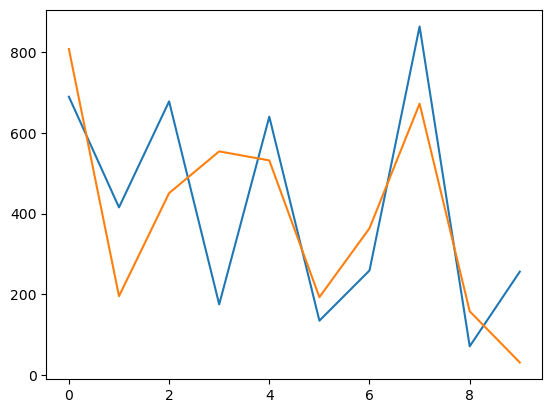

In [22]:
#Plotting current wealth and updated wealth for each agent for one time-step
import matplotlib.pyplot as plt

plt.plot(g.ndata['k'])
plt.plot(g.ndata['k_new'])

In [23]:
print (sum(g.ndata['k']))

tensor([4181.8662])


In [33]:
print (sum(g.ndata['k_new']) + g.ndata['k'][-1])

tensor([4213.1240])


In [25]:
print (sum(g.ndata['disp_wealth']))

tensor([2405.0159])


In [26]:
print (sum(g.ndata['delta_inc']))

tensor([2180.1455])


In [27]:
print (sum(g.edata['trfr_wealth']))

tensor([2180.1450])


In [32]:
for i in eid:
    print (g.edata['per_wgt'][i], g.ndata['disp_wealth'][src[i]], g.edata['trfr_wealth'][i])

tensor([0.1705]) tensor([646.1075]) tensor([110.1620])
tensor([0.3188]) tensor([646.1075]) tensor([205.9955])
tensor([0.5107]) tensor([646.1075]) tensor([329.9500])
tensor([0.8272]) tensor([380.2073]) tensor([314.4943])
tensor([0.1728]) tensor([380.2073]) tensor([65.7130])
tensor([0.8995]) tensor([498.8342]) tensor([448.6964])
tensor([0.1005]) tensor([498.8342]) tensor([50.1378])
tensor([0.3875]) tensor([2.6909]) tensor([1.0426])
tensor([0.1705]) tensor([2.6909]) tensor([0.4587])
tensor([0.4421]) tensor([2.6909]) tensor([1.1897])
tensor([0.3611]) tensor([115.3596]) tensor([41.6604])
tensor([0.6389]) tensor([115.3596]) tensor([73.6992])
tensor([0.5945]) tensor([16.6367]) tensor([9.8906])
tensor([0.4055]) tensor([16.6367]) tensor([6.7460])
tensor([0.8710]) tensor([167.3600]) tensor([145.7752])
tensor([0.1290]) tensor([167.3600]) tensor([21.5849])
tensor([0.7822]) tensor([343.3603]) tensor([268.5634])
tensor([0.2178]) tensor([343.3603]) tensor([74.7969])
tensor([0.3471]) tensor([9.5887]) 

In [34]:
g.ndata['k']

tensor([[689.2941],
        [415.3662],
        [677.7705],
        [175.1773],
        [639.7654],
        [134.7452],
        [259.0610],
        [863.2845],
        [ 71.2737],
        [256.1285]])

In [35]:
g.ndata['k_new']

tensor([[807.4199],
        [195.4588],
        [450.6447],
        [553.9874],
        [531.6105],
        [192.9975],
        [363.5926],
        [671.9598],
        [158.0667],
        [ 31.2580]])

In [36]:
g.ndata['disp_wealth']

tensor([[646.1075],
        [380.2073],
        [498.8342],
        [  2.6909],
        [115.3596],
        [ 16.6367],
        [167.3600],
        [343.3603],
        [  9.5887],
        [224.8705]])